In [1]:
import urllib, json, objectpath
from pprint import pprint

In [2]:
def get_data(route):
    response = urllib.urlopen('http://pendlr.risc-software.at/log?id=["%s"]&num=10000' % route)
    data = json.loads(response.read())
    tree_obj = objectpath.Tree(data)
    return tuple(tree_obj.execute('$..entries'))
def get_route():
    response = urllib.urlopen('http://pendlr.risc-software.at/log?num=10000')
    data = json.loads(response.read())
    tree_obj = objectpath.Tree(data)
    return tuple(tree_obj.execute('$..id'))

The methods above will return json files with the relevent inforamtion, the routes names and the corresponding json.

Todo:
* Get the direction and see which route in close to another
* Merge the current traffic data with the weather data 
* make correlations between weather and traffic

In [3]:
routes = get_route()
cur_data   = {}

for r in routes :
    if 'cur.' in r:
        print "-- route : ", r
        cur_data[r] = get_data(r)

-- route :  cur.einwaerts.haselgraben.traffic.risc-software.at
-- route :  cur.urfahr.b127.traffic.risc-software.at
-- route :  cur.traun.b1.traffic.risc-software.at
-- route :  cur.bindermichl.b1.traffic.risc-software.at
-- route :  cur.auswaerts.bindermichl.traffic.risc-software.at
-- route :  cur.linz.steyreggerbruecke.traffic.risc-software.at
-- route :  cur.linz.autobahnbruecke.traffic.risc-software.at
-- route :  cur.haid.knotenlinz.traffic.risc-software.at
-- route :  cur.wilhering.b129.traffic.risc-software.at
-- route :  cur.einwaerts.bindermichl.traffic.risc-software.at
-- route :  cur.steyregg.steyreggerbruecke.traffic.risc-software.at
-- route :  cur.urfahr.autobahnbruecke.traffic.risc-software.at
-- route :  cur.rohrbach.b127.traffic.risc-software.at
-- route :  cur.florianerstrasse.knotenlinz.traffic.risc-software.at
-- route :  cur.zentrum.nibelungenbruecke.traffic.risc-software.at
-- route :  cur.franzosenhausweg.knotenlinz.traffic.risc-software.at
-- route :  cur.auswa

In [4]:
pprint(cur_data['cur.urfahr.b127.traffic.risc-software.at'  ][0])
pprint(cur_data['cur.rohrbach.b127.traffic.risc-software.at'][0])
pprint("---------------------")
pprint(cur_data['cur.wilhering.b129.traffic.risc-software.at' ][0])
pprint(cur_data['cur.zentrum.b129.traffic.risc-software.at'   ][0])

{u'data': {u'attrs': {u'average_speed': 57.6,
                      u'delay': 6,
                      u'delayed_average_speed': 57.6,
                      u'distance': [10002],
                      u'duration': [615],
                      u'duration_in_traffic': [621],
                      u'total_distance': 10002,
                      u'total_duration': 615,
                      u'total_duration_in_traffic': 621},
           u'nip': u'10.32.5.17',
           u'o_id': u'cur.urfahr.b127.traffic.risc-software.at'},
 u'latency': 111,
 u'ts': 1482327007429}
{u'data': {u'attrs': {u'average_speed': 57.6,
                      u'delay': 44,
                      u'delayed_average_speed': 50.4,
                      u'distance': [9988],
                      u'duration': [624],
                      u'duration_in_traffic': [668],
                      u'total_distance': 9988,
                      u'total_duration': 624,
                      u'total_duration_in_traffic': 668},
        

From these output, we can see that that the usefull features would be the following:

```json
{u'attrs': {
      'average_speed'            : 39.6,
      'delay'                    : 8,
      'delayed_average_speed'    : 39.6,
      'total_distance'           : 4084,
      'total_duration'           : 359,
      'total_duration_in_traffic': 367
      }
}
```

For example the `total_duration` and `duration` are shown be on the same values. So one question rises, why `duration` here is a list and why it has the same value as the total one. 

In [5]:
import pandas as pd 
from pandas.io.json import json_normalize

In [6]:
cur_df = {}
for c in cur_data:
    print '-- route : ', c
    cur_df[c] = json_normalize(cur_data[c])

-- route :  cur.wilhering.b129.traffic.risc-software.at
-- route :  cur.steyregg.steyreggerbruecke.traffic.risc-software.at
-- route :  cur.haid.knotenlinz.traffic.risc-software.at
-- route :  cur.bindermichl.b1.traffic.risc-software.at
-- route :  cur.urfahr.autobahnbruecke.traffic.risc-software.at
-- route :  cur.linz.autobahnbruecke.traffic.risc-software.at
-- route :  cur.urfahr.nibelungenbruecke.traffic.risc-software.at
-- route :  cur.urfahr.b127.traffic.risc-software.at
-- route :  cur.rohrbach.b127.traffic.risc-software.at
-- route :  cur.auswaerts.bindermichl.traffic.risc-software.at
-- route :  cur.franzosenhausweg.knotenlinz.traffic.risc-software.at
-- route :  cur.florianerstrasse.knotenlinz.traffic.risc-software.at
-- route :  cur.zentrum.b129.traffic.risc-software.at
-- route :  cur.zentrum.nibelungenbruecke.traffic.risc-software.at
-- route :  cur.linz.steyreggerbruecke.traffic.risc-software.at
-- route :  cur.einwaerts.haselgraben.traffic.risc-software.at
-- route :  cu

In [7]:
import requests
import io
import pandas as pd
from dateutil import parser, rrule
from datetime import datetime, time, date
import time

def getRainfallData(station, day, month, year):
    """
    Function to return a data frame of minute-level weather data for a single Wunderground PWS station.
    
    Args:
        station (string): Station code from the Wunderground website
        day (int): Day of month for which data is requested
        month (int): Month for which data is requested
        year (int): Year for which data is requested
    
    Returns:
        Pandas Dataframe with weather data for specified station and date.
    """
    url = "http://www.wunderground.com/weatherstation/WXDailyHistory.asp?ID={station}&day={day}&month={month}&year={year}&graphspan=day&format=1"
    full_url = url.format(station=station, day=day, month=month, year=year)
    # print full_url
    # Request data from wunderground data
    response = requests.get(full_url, headers={'User-agent': 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36'})
    data = response.text
    data = data.replace('<br>', '')
    dataframe = pd.read_csv(io.StringIO(data), index_col=False)
    dataframe['station'] = station
    return dataframe
    
# Generate a list of all of the dates we want data for
start_date = "2017-01-01"
end_date   = "2017-03-15"
start = parser.parse(start_date)
end = parser.parse(end_date)
dates = list(rrule.rrule(rrule.DAILY, dtstart=start, until=end))

# Create a list of stations here to download data for
stations = [
    'IUPPERAU8'
]

# # Set a backoff time in seconds if a request fails
backoff_time = 10
data = {}
# Gather data for each station in turn and save to CSV.
for station in stations:
    print("Working on {}".format(station))
    data[station] = []
    for date in dates:
        # Print period status update messages
        if date.day % 10 == 0:
            print("Working on date: {} for station {}".format(date, station))
        done = False
        while done == False:
            try:
                weather_data = getRainfallData(station, date.day, date.month, date.year)
                done = True
            except ConnectionError as e:
                # May get rate limited by Wunderground.com, backoff if so.
                print("Got connection error on {}".format(date))
                print("Will retry in {} seconds".format(backoff_time))
                time.sleep(10)
        # Add each processed date to the overall data
        data[station].append(weather_data)
    # Finally combine all of the individual days and output to CSV for analysis.
    pd.concat(data[station]).to_csv("{}_weather.csv".format(station))
    

Working on IUPPERAU8
Working on date: 2017-01-10 00:00:00 for station IUPPERAU8
Working on date: 2017-01-20 00:00:00 for station IUPPERAU8
Working on date: 2017-01-30 00:00:00 for station IUPPERAU8
Working on date: 2017-02-10 00:00:00 for station IUPPERAU8
Working on date: 2017-02-20 00:00:00 for station IUPPERAU8
Working on date: 2017-03-10 00:00:00 for station IUPPERAU8


In [8]:
df_weather = pd.concat(data['IUPPERAU8'],ignore_index=True)

After the normalisation of the json file, to make it easy to read, someone can use one root to extract the all the available features. But earlier we showed the most interetsing features so we are going to take those as the feature that we want to analyse

In [9]:
feat_traffic =  [
    'time',
    'data.attrs.delay'                    ,
    'data.attrs.average_speed'            ,
    'data.attrs.delayed_average_speed'    ,
    'data.attrs.total_distance'           ,
    'data.attrs.total_duration'           ,
    'data.attrs.total_duration_in_traffic'
]
feat_weather =  [
    'time', 
    'TemperatureC', 
    'DewpointC', 
    'PressurehPa', 
    'WindDirectionDegrees', 
    'WindSpeedKMH', 
    'WindSpeedGustKMH',
    'Humidity', 
    'HourlyPrecipMM', 
    'dailyrainMM'
]

### Running an example on just one route

let selection the `b129` root one of busiest route,

In [10]:
import numpy as np
df_traffic = cur_df['cur.zentrum.b129.traffic.risc-software.at']
df_traffic['time'] = pd.to_datetime(df_traffic['ts']/1000.0, unit='s')
df_traffic = df_traffic[feat_traffic]

df_weather["time"] = pd.to_datetime(df_weather['Time'], format='%Y-%m-%d %H:%M:%S')
df_weather = df_weather[feat_weather]

In [11]:
import time
from dateutil import parser, rrule
from datetime import datetime, time, date

def uniformise_dataframe(data = pd.DataFrame()):
    print "shape :: ", data.shape
    data_copy = data
    data_copy.is_copy = False
    data_copy['hour'] = data_copy.time.apply(lambda x: datetime(x.year, x.month, x.day, x.hour) )
    data_copy = data_copy.reset_index().groupby(['hour']).mean()
    data_copy.reset_index(inplace=True)
    data_copy = data_copy.set_index(data_copy.hour.values)
    data_copy = data_copy.drop('hour' , 1)
    data_copy = data_copy.drop('index', 1)
    return data_copy

In [12]:
uniformise_dataframe(df_weather).head()

shape ::  (5007, 10)


,TemperatureC,DewpointC,PressurehPa,WindDirectionDegrees,WindSpeedKMH,WindSpeedGustKMH,Humidity,HourlyPrecipMM,dailyrainMM
2017-01-01 00:00:00,-3.200000,-6.300000,1029.500000,90.0,1.0,-1607.4,84.0,-2539.7,-2539.7
2017-01-01 01:00:00,-3.200000,-6.300000,1029.000000,90.0,1.0,-1607.4,84.0,-2539.7,-2539.7
2017-01-01 02:00:00,-4.200000,-7.300000,1028.000000,90.0,1.0,-1607.4,84.0,-2539.7,-2539.7
2017-01-01 03:00:00,-4.400000,-7.500000,1027.150000,90.0,1.0,-1607.4,84.0,-2539.7,-2539.7
2017-01-01 04:00:00,-4.433333,-7.533333,1026.733333,90.0,1.0,-1607.4,84.0,-2539.7,-2539.7


In [13]:
df_traffic = uniformise_dataframe(df_traffic)
df_weather = uniformise_dataframe(df_weather)

shape ::  (9680, 7)
shape ::  (5007, 11)


In [14]:
print "selecting only dates from the 01-01-2017 to today"
df_traffic = df_traffic.loc["2017-1-6":"2017-3-16"]
df_weather = df_weather.loc["2017-1-6":"2017-3-16"]

print df_traffic.shape
print df_weather.shape

selecting only dates from the 01-01-2017 to today
(1588, 6)
(1645, 9)


Let combine the two dataframe for a single datset

In [15]:
df = pd.concat([df_weather, df_traffic], axis=1)

Now let build some seasonal features such as :
* day of the year 
* hour in the day : we know that there is a reccurences during the day on the delay, for example when going for work
* day of the week : the delay should be different from weekend day then a working day

In [16]:
feat_time = ['day','dow','hod','working_day']

def fill_timefeatures(data = pd.DataFrame(), date_interval = ["2017-01-01", "2017-03-15"]):
    print "shape :: ", data.shape
    data_copy = data
    data_copy.is_copy = False
    data_copy['day' ] = data.index.date
    data_copy['dow' ] = data.index.weekday   
    data_copy['hod' ] = data.index.hour
    # Is each time stamp on a working day (Mon-Fri)
    data_copy['working_day'] = (data_copy['dow'] >= 0) & (data_copy['dow'] <= 4)
    return data_copy

In [17]:
df = fill_timefeatures(df)

shape ::  (1671, 15)


In [18]:
df.head()

,TemperatureC,DewpointC,PressurehPa,WindDirectionDegrees,WindSpeedKMH,WindSpeedGustKMH,Humidity,HourlyPrecipMM,dailyrainMM,data.attrs.delay,data.attrs.average_speed,data.attrs.delayed_average_speed,data.attrs.total_distance,data.attrs.total_duration,data.attrs.total_duration_in_traffic,day,dow,hod,working_day
2017-01-06 00:00:00,-4.133333,-8.333333,1031.933333,210.000000,1.300000,-1607.4,78.0,-2539.7,-2539.7,0.166667,39.6,39.6,4084.0,359.0,352.166667,2017-01-06,4,0,True
2017-01-06 01:00:00,-5.200000,-9.400000,1032.500000,44.666667,0.666667,-1607.4,78.0,-2539.7,-2539.7,0.000000,39.6,39.6,4084.0,359.0,353.000000,2017-01-06,4,1,True
2017-01-06 02:00:00,-6.133333,-10.333333,1033.533333,119.666667,0.666667,-1607.4,78.0,-2539.7,-2539.7,0.000000,39.6,39.6,4084.0,359.0,342.666667,2017-01-06,4,2,True
2017-01-06 03:00:00,-6.433333,-10.633333,1034.300000,119.666667,0.666667,-1607.4,78.0,-2539.7,-2539.7,12.500000,39.6,39.0,4084.0,359.0,365.500000,2017-01-06,4,3,True
2017-01-06 04:00:00,-7.366667,-11.566667,1034.900000,29.333333,0.333333,-1607.4,78.0,-2539.7,-2539.7,10.333333,39.6,38.4,4084.0,359.0,360.166667,2017-01-06,4,4,True


Let create a calendar vosualtion of the average delay

TemperatureC   (1671,)
DewpointC   (1671,)


/home/user/.local/lib/python2.7/site-packages/calmap/__init__.py:128: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  by_day = data.resample('D', how=how)


PressurehPa   (1671,)
WindDirectionDegrees   (1671,)
WindSpeedKMH   (1671,)
WindSpeedGustKMH   (1671,)
Humidity   (1671,)
HourlyPrecipMM   (1671,)
dailyrainMM   (1671,)
data.attrs.delay   (1671,)
data.attrs.average_speed   (1671,)
data.attrs.delayed_average_speed   (1671,)
data.attrs.total_distance   (1671,)
data.attrs.total_duration   (1671,)
data.attrs.total_duration_in_traffic   (1671,)


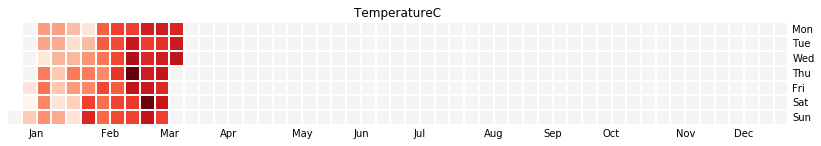

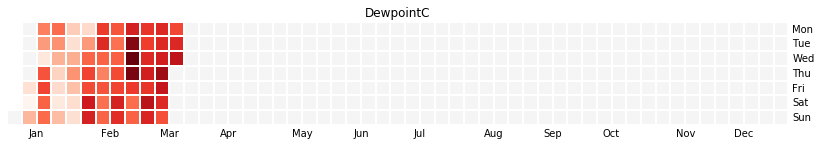

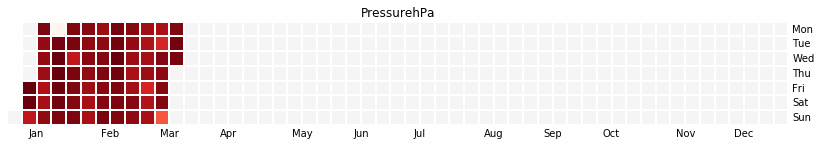

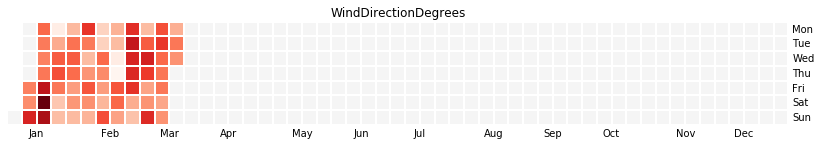

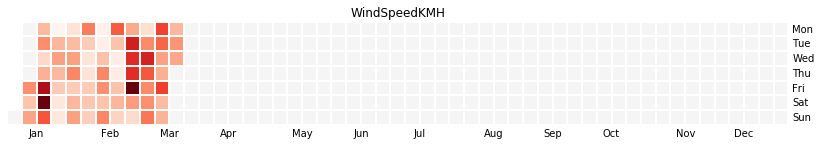

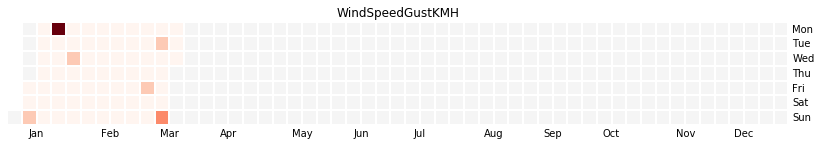

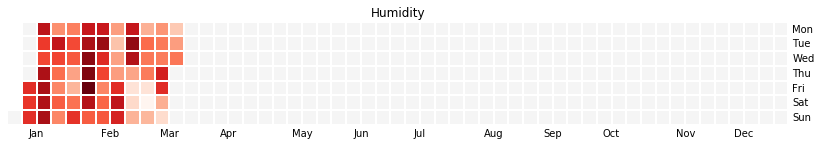

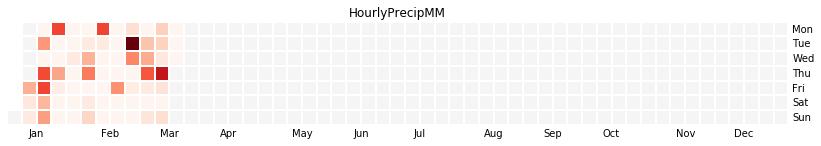

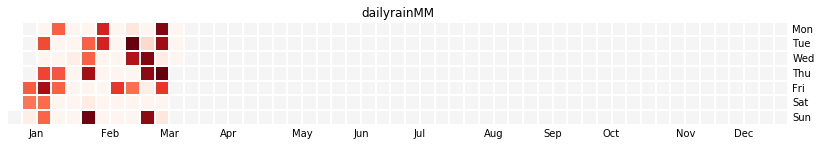

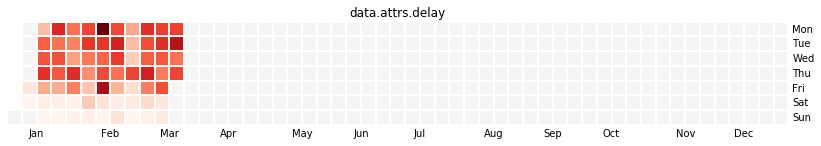

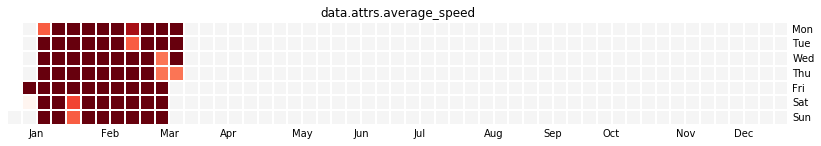

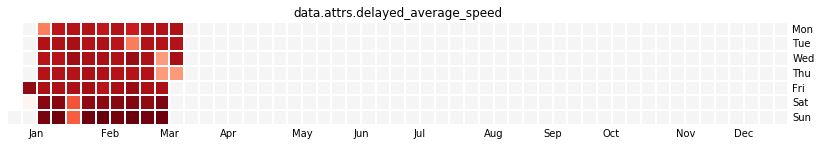

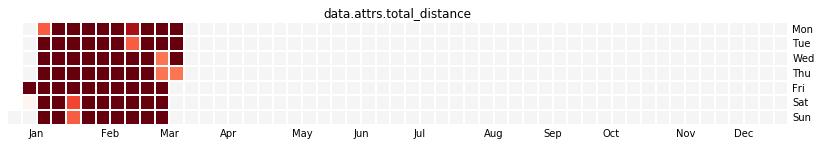

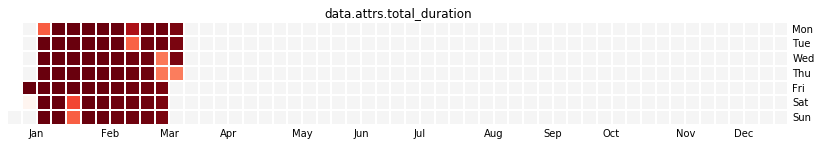

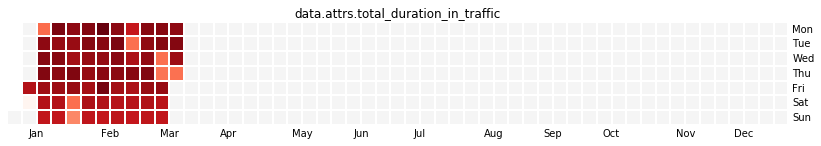

In [19]:
import matplotlib.pyplot as plt
import calmap
import numpy  as np
import pandas as pd
from matplotlib import dates

%matplotlib inline
features  = feat_weather[1:] + feat_traffic[1:]
for feat in features:
    print feat ,' ',df[feat].shape
    dev_sr = pd.Series(df[feat].values, index=df.index)
    plt.figure(figsize=(14,5))
    calmap.yearplot(dev_sr, year=2017)
    plt.title(feat)

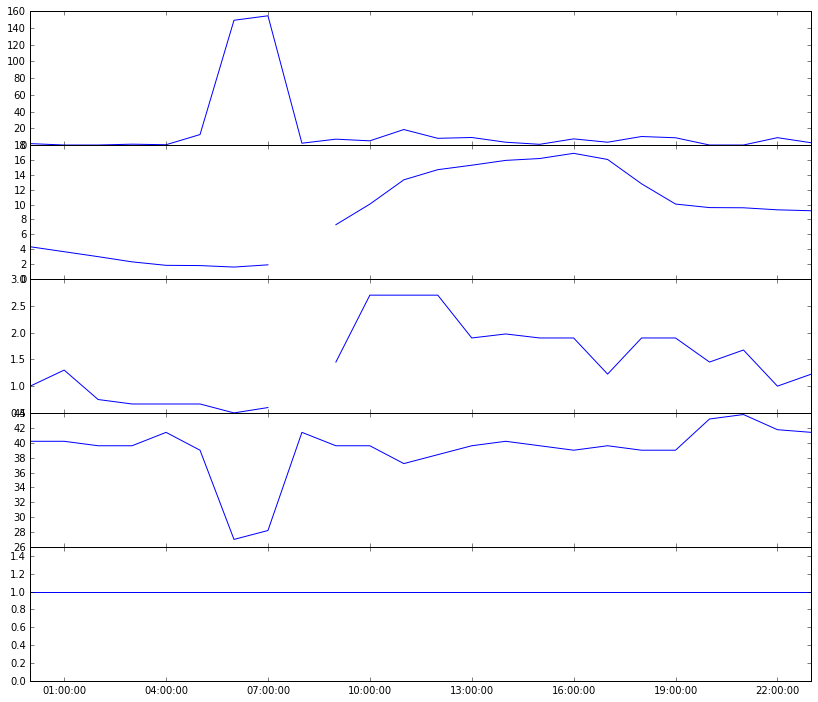

In [20]:
f = plt.figure(figsize=(14,12))
plt.subplots_adjust(hspace=0.001)

period = ['2017-03-3','2017-03-3']

ax1 = plt.subplot(511)
ax1.plot(df.loc[period[0]:period[1]]['data.attrs.delay'])

ax2 = plt.subplot(512, sharex=ax1)
ax2.plot(df.loc[period[0]:period[1]]['TemperatureC'])

ax3 = plt.subplot(513, sharex=ax1)
ax3.plot(df.loc[period[0]:period[1]]['WindSpeedKMH'])

ax4 = plt.subplot(514, sharex=ax1)
ax4.plot(df.loc[period[0]:period[1]]['data.attrs.delayed_average_speed'])

ax5 = plt.subplot(515, sharex=ax1)
ax5.plot(df.loc[period[0]:period[1]]['working_day'])
ax5.set_ylim([0,1.5])
xticklabels = ax1.get_xticklabels() + ax2.get_xticklabels() + ax3.get_xticklabels() + ax4.get_xticklabels()
plt.setp(xticklabels, visible=False)

plt.show()

In [21]:
df = df.fillna(0)

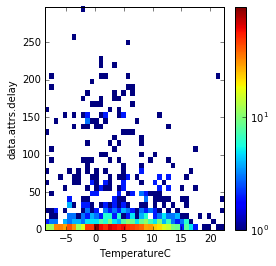

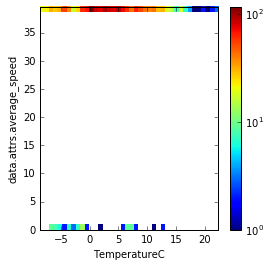

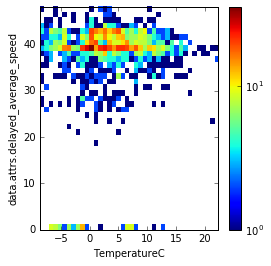

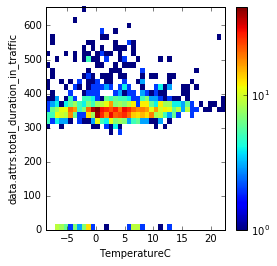

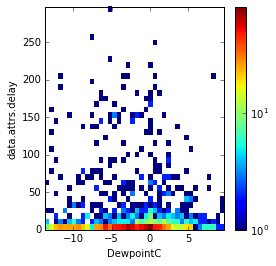

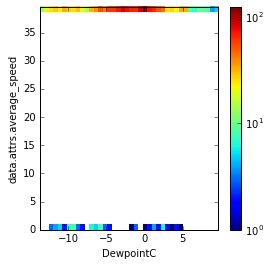

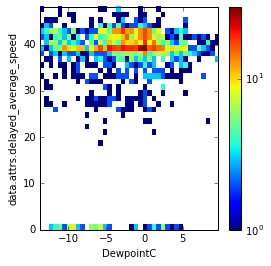

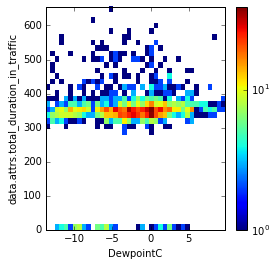

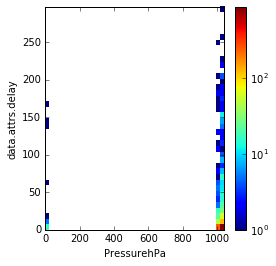

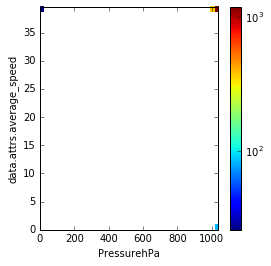

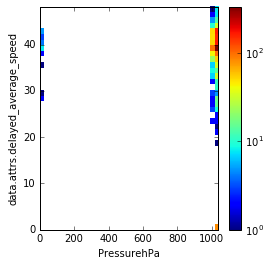

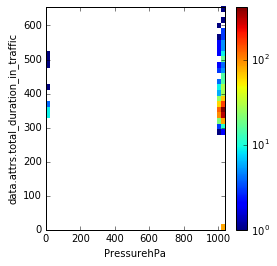

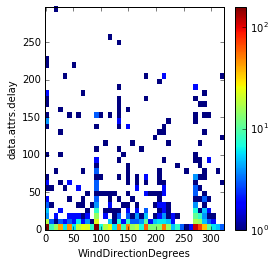

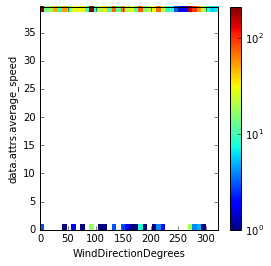

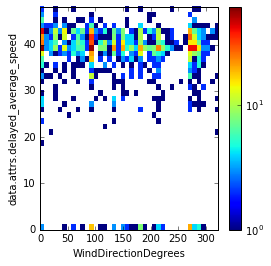

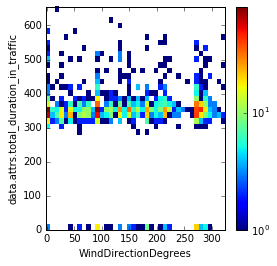

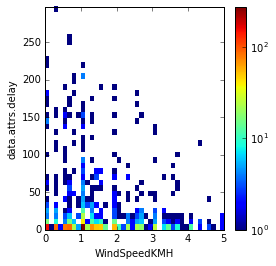

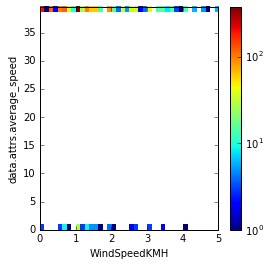

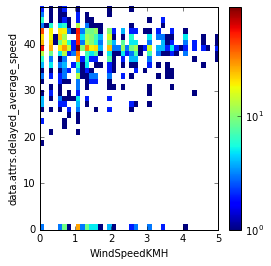

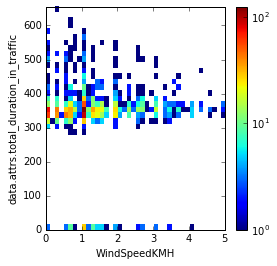

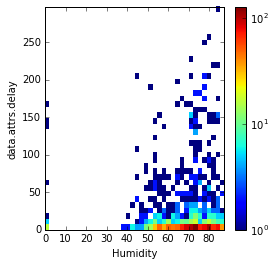

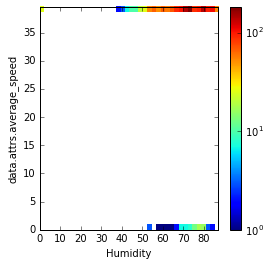

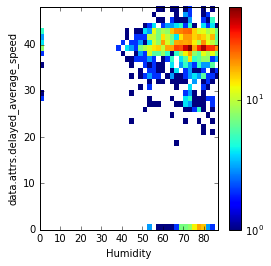

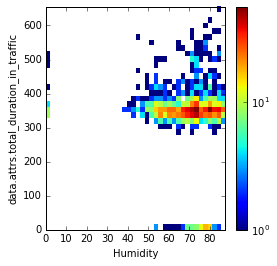

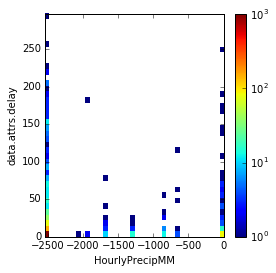

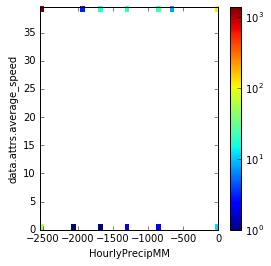

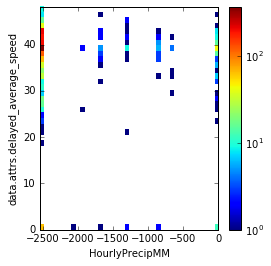

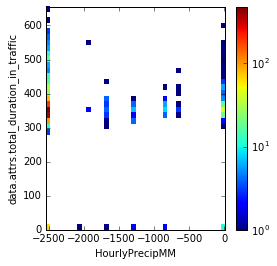

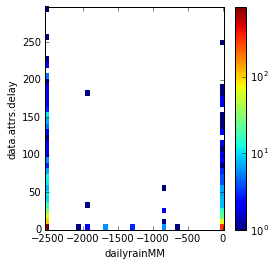

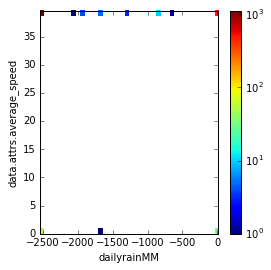

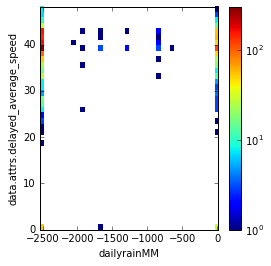

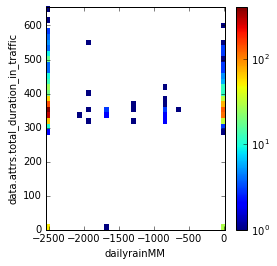

In [22]:
from matplotlib.colors import LogNorm

varx = ['TemperatureC', 'DewpointC', 'PressurehPa',
             'WindDirectionDegrees', 'WindSpeedKMH', 'Humidity',
             'HourlyPrecipMM', 'dailyrainMM']
vary = [
    'data.attrs.delay', 
    'data.attrs.average_speed',
    'data.attrs.delayed_average_speed',
    'data.attrs.total_duration_in_traffic'
]
for fx in varx:
    for fy in vary:
        if fx == fy : continue
        xmin, xmax = np.percentile(df[fx], [1, 99.9])
        ymin, ymax = np.percentile(df[fy], [1, 99.9])
        plt.figure(figsize=(4,4))
        plt.hist2d(df[fx], df[fy], bins=40, range=[[xmin,xmax],[ymin,ymax]] ,  norm=LogNorm())
        plt.colorbar()
        plt.xlabel(fx)
        plt.ylabel(fy)
        plt.show()

In [23]:
def correlations(data,label, title, **kwds):
        """
        Calculate pairwise correlation between features.
        Extra arguments are passed on to DataFrame.corr()
        bg  = df.y < 0.5
        sig = df.y > 0.5
        """
        corrmat = data.corr(**kwds)

        fig, ax1 = plt.subplots(ncols=1, figsize=(9,8))

        opts = {'cmap': plt.get_cmap("RdBu"),
                'vmin': -1, 'vmax': +1}
        heatmap1 = ax1.pcolor(corrmat, **opts)
        plt.colorbar( heatmap1, ax=ax1 )
        if title is None :  title = ""
        ax1.set_title( "Correlations : %s" % title )

        labels = corrmat.columns.values
        for ax in (ax1,):
            # shift location of ticks to center of the bins
            ax.set_xticks(np.arange(len(labels))+0.5, minor=False)
            ax.set_yticks(np.arange(len(labels))+0.5, minor=False)
            ax.set_xticklabels(labels, minor=False, ha='right', rotation=70)
            ax.set_yticklabels(labels, minor=False)
        plt.tight_layout()
        plt.savefig('correlation_' + label + '.pdf')

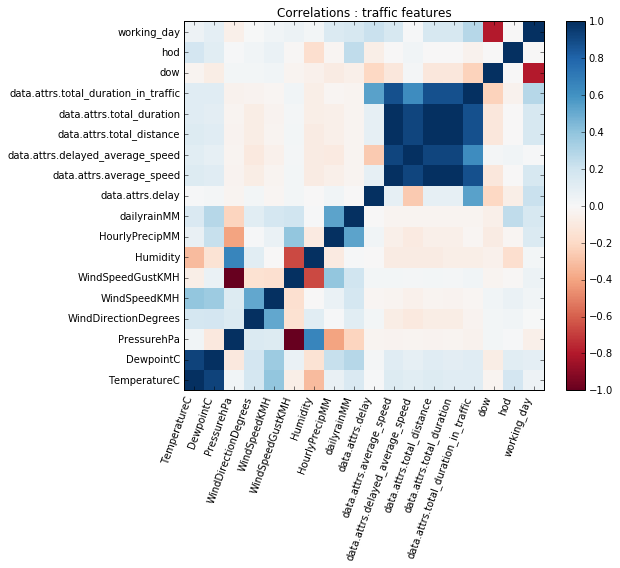

In [24]:
correlations(  data=df,title = "traffic features", label = 'traffic_')

let take a sub-sample of the time serie that I extracted from the DB, let make it the febrary mounth and let call it trainning sample

In [25]:
df_train = df.loc["2017-02-01":"2017-02-28"]
df_valid = df.loc["2017-03-01":"2017-03-02"]
df_total = df.loc["2017-02-01":"2017-03-02"]

In [26]:
ewma = pd.stats.moments.ewma
EMOV_n = ewma(df_train['data.attrs.delay'] , com=5 )

/home/user/.local/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(ignore_na=False,min_periods=0,adjust=True,com=5).mean()
  from ipykernel import kernelapp as app


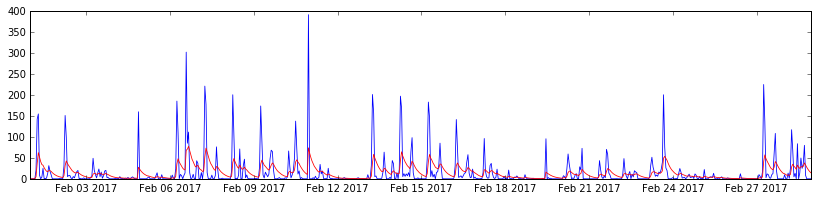

In [27]:
plt.figure(figsize=(14,3))
plt.plot(df_train['data.attrs.delay'], lw=0.8, label = "data")
plt.plot(df_train.index, EMOV_n      , lw=0.8, label = "ewma", c = "red")
plt.show()

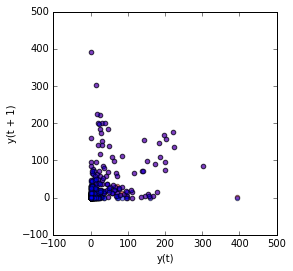

In [28]:
from pandas.tools.plotting import lag_plot
plt.figure(figsize=(4,4))
lag_plot(df_train['data.attrs.delay'][df_train["data.attrs.delay"]>0], c='red', alpha=0.5)
lag_plot(df_train['data.attrs.delay'],alpha=0.5)
plt.show()

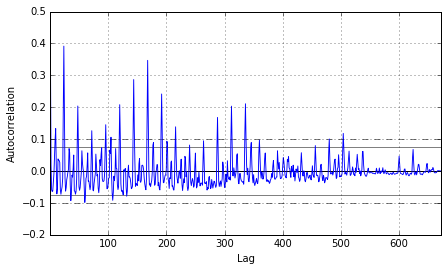

In [29]:
from pandas.tools.plotting import autocorrelation_plot
plt.figure(figsize=(7,4))
autocorrelation_plot(df_train['data.attrs.delay'], lw=0.9)
plt.ylim([-0.2,0.5])
plt.show()

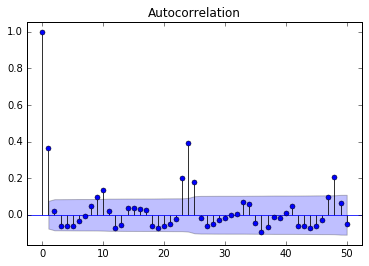

In [30]:
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(4,4))
plot_acf(df_train['data.attrs.delay'], lw=0.8, lags=50)
plt.show()

In [31]:
values = pd.DataFrame(df_train['data.attrs.delay'].values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

         t-1      t+1
t-1  1.00000  0.36264
t+1  0.36264  1.00000


In [32]:
import numpy as np

def organize_data(to_forecast, window, horizon):
    """
     Input:
      to_forecast, univariate time series organized as numpy array
      window, number of items to use in the forecast window
      horizon, horizon of the forecast
     Output:
      X, a matrix where each row contains a forecast window
      y, the target values for each row of X
    """
    shape = to_forecast.shape[:-1] + (to_forecast.shape[-1] - window + 1, window)
    strides = to_forecast.strides + (to_forecast.strides[-1],)
    X = np.lib.stride_tricks.as_strided(to_forecast, 
                                        shape=shape, 
                                        strides=strides)
    y = np.array([X[i+horizon][-1] for i in range(len(X)-horizon)])
    return X[:-horizon], y

k = 4   # number of previous observations to use
h = 24   # forecast horizon
X,y = organize_data(df_train['data.attrs.delay'].values, k, h)

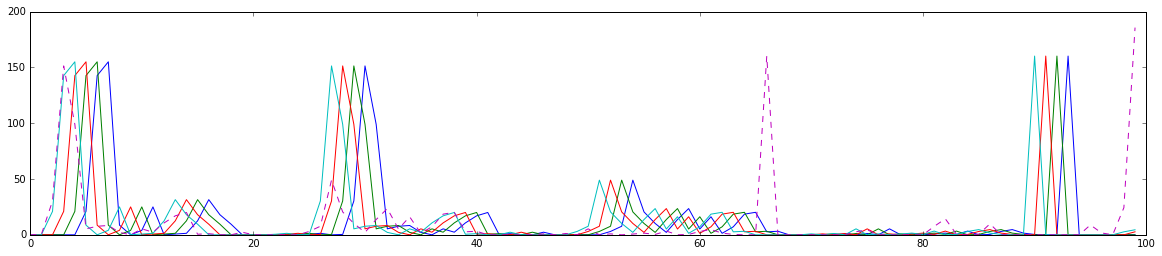

In [33]:
plt.figure(figsize=(20,4))
plt.plot(X[:100,0])
plt.plot(X[:100,1])
plt.plot(X[:100,2])
plt.plot(X[:100,3])
plt.plot(y[:100],'--')

In [34]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression(normalize=True)
regressor.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [35]:
def mape(ypred, ytrue):
    """ returns the mean absolute percentage error """
    idx = ytrue != 0.0
    return 100*np.mean(np.abs(ypred[idx]-ytrue[idx])/ytrue[idx])

print 'The error is %0.2f%%' % mape(regressor.predict(X[m:]),y[m:])

NameError: name 'm' is not defined

## Let play with a signle time serie

In [53]:
ts     = df_train['data.attrs.delay']
ts_std = (ts - ts.mean())/ts.std()

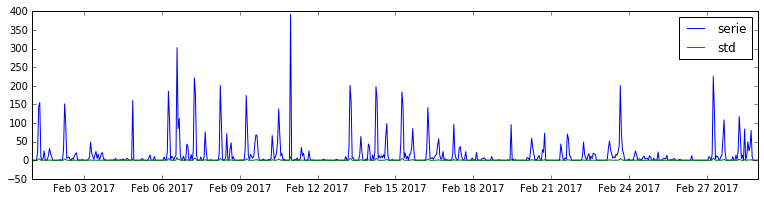

In [56]:
fig, ax = plt.subplots(figsize=(13,3))
ax.plot(ts, label='serie')
ax.plot(ts_std, label='std')
ax.legend()

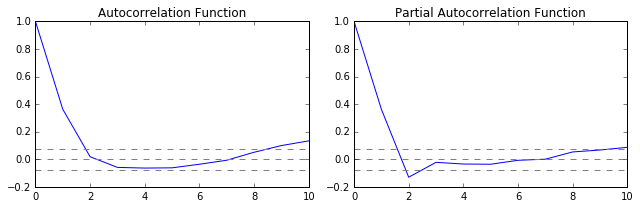

In [57]:
from statsmodels.tsa.stattools import acf, pacf

plt.figure(figsize=(9,3))
lag_acf  = acf (ts, nlags=10)
lag_pacf = pacf(ts, nlags=10, method='ols')

plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.axhline(y= 1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.axhline(y= 1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

plt.show()

In [39]:
from statsmodels.tsa.arima_model import ARIMA

/home/user/.local/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


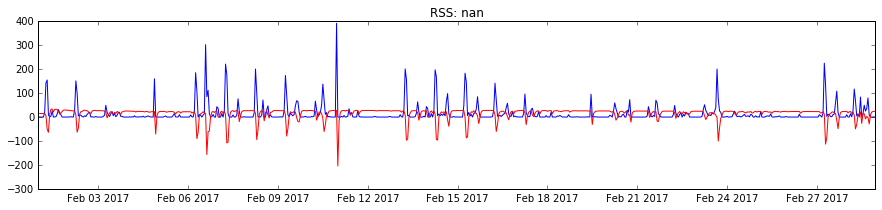

In [80]:
model = ARIMA(ts_std, order=(2, 1, 2))  
results_AR = model.fit(disp=1) 

plt.figure(figsize=(15,3))
plt.plot (ts)
plt.plot ((results_AR.fittedvalues*ts.std() + ts.mean()), color='red')
plt.title('RSS: %.4f'% (sum((results_AR.fittedvalues-ts)**2)/ts.shape[0]) )